In [18]:
#downloading the dataset:
# !curl -L -o ../data/caltech-101.zip https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip
# !unzip ../data/caltech-101.zip -d ../data/caltech-101
# !tar -xzvf ../data/caltech-101/caltech-101/101_ObjectCategories.tar.gz -C ../data/
# !mv ../data/101_ObjectCategories/ ../data/caltech_images
# !rm -R ../data/caltech-101/
# !rm ../data/caltech-101.zip
# !rm -R ../data/caltech_images/101_ObjectCategories/

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# tensorflow imports

import tensorflow as tf
import tensorflow.keras.layers as layers
# from tensorflow.keras.layers import Conv2D , MaxPooling2D , concatenate , Input
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import load_img , img_to_array





plt.style.use('dark_background')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('dark'))

In [20]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
	# 1x1 conv
	conv1 = layers.Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	# 3x3 conv
	conv3 = layers.Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = layers.Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
	# 5x5 conv
	conv5 = layers.Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
	conv5 = layers.Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
	# 3x3 max pooling
	pool = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	pool = layers.Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
	# concatenate filters, assumes filters/channels last
	layer_out = layers.concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out

In [21]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    F1,F2,F3 = filter
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(F1, (1,1), padding = 'valid')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(F2, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Layer 3
    x = tf.keras.layers.Conv2D(F3, (1,1), padding = 'valid')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def convolutional_block(x, s,filters):
    # copy tensor to variable called x_skip
    x_skip = x
    F1,F2,F3 =filters
    # Layer 1
    x = tf.keras.layers.Conv2D(F1, (1,1), padding = 'valid', strides = (s,s))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(F2, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 3
    x = tf.keras.layers.Conv2D(F3, (1,1), padding = 'valid')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(F3, (1,1),padding = 'valid', strides = (s,s))(x_skip)
    x_skip = tf.keras.layers.BatchNormalization(axis=3)(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [ ]:
def ResNet_50(input_shape=(224, 224, 3)):

    X_input = layers.Input(input_shape)

    X = tf.keras.layers.ZeroPadding2D((3, 3))(X_input)

    #stage 1


    X = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer=glorot_uniform(seed=0))(X)
    X = tf.keras.layers.BatchNormalization(axis=3)(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)


    #stage 2

    X = convolutional_block(X, s=1, filters=[64, 64, 256])
    X = identity_block(X, [64, 64, 256])
    X = identity_block(X, [64, 64, 256])


    #stage 3


    X = convolutional_block(X,s=2, filters=[128, 128, 512])
    X = identity_block(X, [128, 128, 512])
    X = identity_block(X, [128, 128, 512])
    X = identity_block(X, [128, 128, 512])


    #stage 4

    X = convolutional_block(X,s=2, filters=[256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])
    X = identity_block(X, [256, 256, 1024])

    #stage 5

    X = convolutional_block(X,s=2, filters=[512, 512, 2048])
    X = identity_block(X, [512, 512, 2048])
    X = identity_block(X, [512, 512, 2048])


    X = tf.keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    model = tf.keras.models.Model(inputs=X_input, outputs=X, name='ResNet50')

    return model
rmodel = ResNet_50()
print(f"{rmodel.count_params()} parameters, distributed among {len(rmodel.layers)} layers!")
rmodel.summary()

In [ ]:
# time for trained model:

model = tf.keras.applications.resnet50.ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3),
                         pooling='avg'
                        )
model.trainable = False
model.summary()

In [24]:
from tensorflow.keras.preprocessing import image
def extract_features(image_path , model):
    img = tf.keras.utils.load_img(image_path , target_size= (224 , 224))
    image_arr = img_to_array(img)
    eimage = np.expand_dims(image_arr , axis = 0)
    processed_image = tf.keras.applications.resnet50.preprocess_input(eimage)
    features = model.predict(processed_image)
    ffeatures = features.flatten()
    return ffeatures / np.linalg.norm(ffeatures)

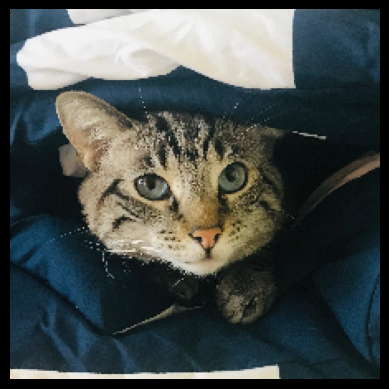

In [25]:
# import gdown
# gdown.download("https://drive.google.com/uc?id=1rOaOGw-SFH_lp8Sx8wRAksU79M8Wz8k4" , "../data/rough/cat.jpg" , quiet = False)

ipath = '../data/rough/cat.jpg'
cimage = load_img(ipath , target_size=(224 , 224))
aimage = img_to_array(cimage)
plt.imshow(cimage)
plt.axis('off')
plt.show()

In [26]:
features = extract_features(ipath , model)
features.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


(2048,)

In [33]:
# get all the image files from a root directory:
import os
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_files(root_dir):
    files = []
    for root , directories , filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file = os.path.join(root , filename)
                if os.path.exists(file):
                    files.append(file)
                else:
                    print(f"File not uploaded: {file}")
    sorted(files)
    return files
imagefiles = get_files('../data/caltech_images')
len(imagefiles)

9144

In [44]:
batchsize = 128

dataset = tf.keras.utils.image_dataset_from_directory('../data/caltech_images' , shuffle = False , batch_size= batchsize , image_size= (224 , 224))

nimages = len(dataset.file_paths)
nepochs = int(np.ceil(nimages / batchsize))


stime = time.time()
featurelist = []
featurelist = model.predict(dataset)
etime = time.time()

Found 9144 files belonging to 102 classes.
72/72 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step


In [45]:
for i , feature in enumerate(featurelist):
    featurelist[i] = feature / np.linalg.norm(feature)

flist = featurelist.reshape(len(featurelist) , -1)

print(f"Num Images: {len(dataset.file_paths)} , \nshape of feature_list = {flist.shape} \n Time taken: {(etime - stime)/60}")

Num Images: 9144 , 
shape of feature_list = (9144, 2048) 
 Time taken: 2.1846496502558392
